In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import spectrogram
import pandas as pd

In [2]:
# Make a damped sine wave
def make_sine(L, period, decay_start, decay_rate):
    x = np.linspace(0, (L / period) * 2 * np.pi, num=L)
    decay_x = x[decay_start]
    print(decay_x)
    decay_factor = np.exp(-np.maximum(0, (decay_rate * (x - decay_x))))
    y = decay_factor * (1 + np.sin(x)) / 2
    return x, y

31.573795513465257


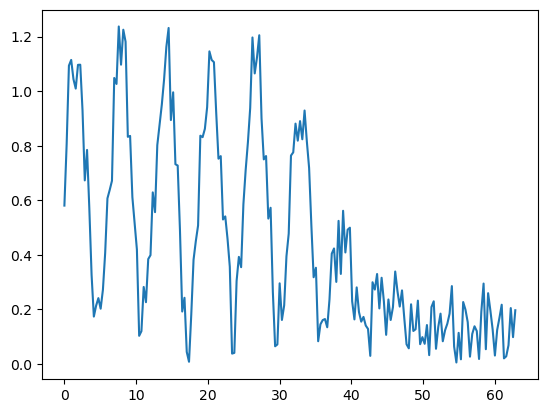

In [3]:
L = 200
period = 20
decay_start = 100
decay_rate = 0.17
x, y = make_sine(L, period, decay_start, decay_rate)
# add noise
y += np.random.random(y.size) * 0.30
plt.plot(x, y)

In [4]:
window_size = 50
def max_of_power_spectrum(signal):
    '''
    Ignores the power of a spectrum at 0.
    '''
    ps = (np.abs(np.fft.fft(signal)) ** 2)
    ps_gt0 = ps[1:ps.size//2]
    return np.max(ps_gt0)

def lag_autocorrelation(signal, lag=1):
    return np.corrcoef(signal[:-lag], signal[lag:])[0, 1]

output_length = y.size - window_size
output = np.zeros((output_length, 3))

for i in range(output_length):
    this_window = y[i:i+window_size]
    output[i, 0] = max_of_power_spectrum(this_window)
    output[i, 1] = lag_autocorrelation(this_window)
    output[i, 2] = np.var(this_window)
    

In [5]:
x[1] - x[0]

0.3157379551346526

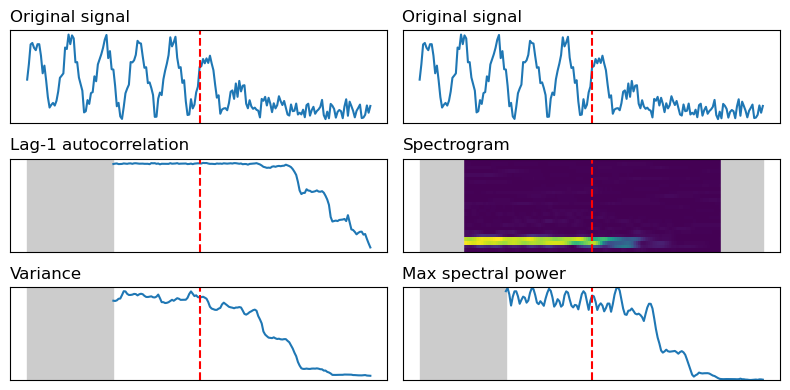

In [6]:
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(8, 4))


f, t, Sxx = spectrogram(y, nperseg=50, noverlap=49, fs=1/(x[1] - x[0]))

x_window_metrics = x[window_size:]
axes[0, 0].plot(x, y)
axes[0, 0].set_title("Original signal", ha="left", x=0)

axes[0, 1].plot(x, y)
axes[0, 1].set_title("Original signal", ha="left", x=0)

axes[1, 1].pcolormesh(t, f, Sxx)
axes[1, 1].set_title("Spectrogram", ha="left", x=0)
axes[1, 1].axvspan(0, x[25], color="0.8")
axes[1, 1].axvspan(x[175], x[-1], color="0.8")

axes[2, 1].plot(x_window_metrics, output[:, 0])
axes[2, 1].set_title("Max spectral power", ha="left", x=0)

axes[1, 0].plot(x_window_metrics, output[:, 1])
axes[1, 0].set_title("Lag-1 autocorrelation", ha="left", x=0)

axes[2, 0].plot(x_window_metrics, output[:, 2])
axes[2, 0].set_title("Variance", ha="left", x=0)

for a in axes.flat[[2, 4, 5]]:
    a.axvspan(0, x[window_size], color="0.8")

for a in axes.flat:
    a.yaxis.set_visible(False)
    a.xaxis.set_visible(False)
    a.axvline(x[decay_start], color="red", linestyle='--')

plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

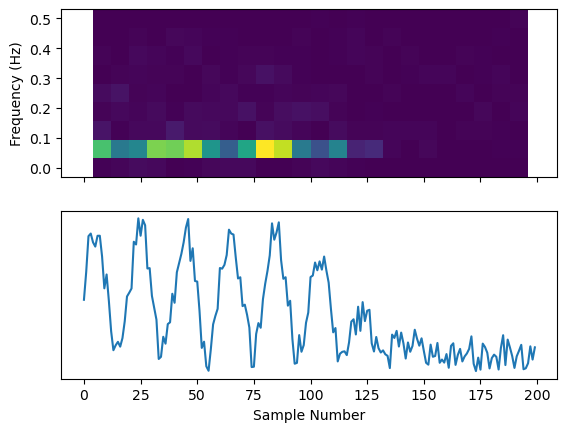

In [7]:
from scipy.signal import spectrogram

f, t, Sxx = spectrogram(y, nperseg=16, noverlap=8)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.pcolormesh(t, f, Sxx)
ax1.set_ylabel("Frequency (Hz)")
ax2.plot(y)
ax2.yaxis.set_visible(False)
ax2.set_xlabel("Sample Number")
plt.show()

In [25]:
# Test on real data
vodca = pd.read_csv("../data_working/cougar_valley_vodca.csv")\
    .rename(columns={"system:time_start":"date"})

vodca["date"] = pd.to_datetime(vodca["date"])
vodca = vodca.set_index("date")

# resample to weekly mean and interpolate periods without data
vodca = vodca.resample("7D").mean().interpolate()

# center the signal and remove long-term trend
vodca["b1_center"] = vodca.b1 - np.mean(vodca.b1)
vodca.head()

,b1,b1_center
date,,
2012-01-01,0.577333,-0.063821
2012-01-08,0.516500,-0.124655
2012-01-15,0.554000,-0.087155
2012-01-22,0.544500,-0.096655
2012-01-29,0.531000,-0.110155


In [26]:
np.any(np.isnan(vodca.b1))

False

In [30]:
vodca.b1_center

date
2012-01-01   -0.063821
2012-01-08   -0.124655
2012-01-15   -0.087155
2012-01-22   -0.096655
2012-01-29   -0.110155
                ...   
2018-12-02   -0.048488
2018-12-09   -0.032488
2018-12-16   -0.031655
2018-12-23   -0.071155
2018-12-30   -0.063155
Freq: 7D, Name: b1_center, Length: 366, dtype: float64

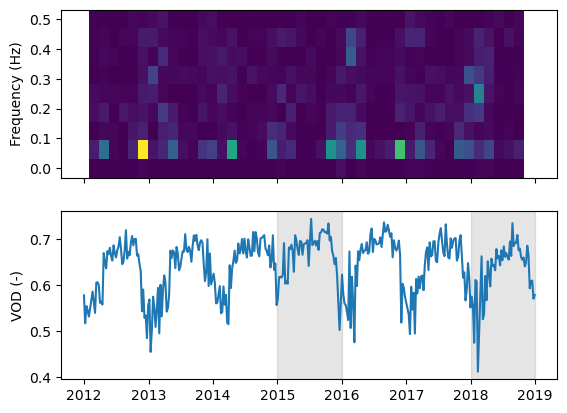

In [43]:
f, t, Sxx = spectrogram(vodca.b1, nperseg=16, noverlap=8)
t = vodca.index[t.astype(np.int16)]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

mort_years = [2015, 2018]

ax1.pcolormesh(t, f, Sxx)
ax1.set_ylabel("Frequency (Hz)")

for y in mort_years:
    start = pd.to_datetime("{}-01-01".format(y), format="%Y-%m-%d")
    end = pd.to_datetime("{}-12-31".format(y), format="%Y-%m-%d")
    ax2.axvspan(start, end, color="black", alpha=0.1)

ax2.plot(vodca.b1)
ax2.set_ylabel("VOD (-)")
    
plt.show()